Neural Style Transfer in Keras
Code obtained and edited from F. Chollet (Created of Keras)

https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.3-neural-style-transfer.ipynb

Prima data defini tinta si sitilul de referinta al imagini
  - tinta este potografia pe care vrem sa apicam un stil artisic
  - stilul de referinta este imaginea stilului artisitic pe care vrem sa o copiem  

In [1]:
from keras.preprocessing.image import load_img, img_to_array

ntName = "es"

#Acesta este calea spre imaginea pe care vrem sa o transformam
target_image_path = 'c:/Users/Harum/Documents/23/images/eiffel.jpg'

#Aceasta este calea spre stilul imagini pe care vrem sa il copiem
style_reference_image_path = 'c:/Users/Harum/Documents/23/images/starrynight.jpg'

result_prefix = style_reference_image_path.split('images/')[1][:-4] + '_onto_' + target_image_path.split("images/")[1][:-4]

#Dimensiunea fotografie generate
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

Using TensorFlow backend.


# Defini cateva functi ajutatoare pe care le vom folosi

In [2]:
import numpy as np
from keras.applications import vgg16

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

def deprocess_image(x):
    #sterge zero -centru pixel
    x[:, :, 0] +=103.939
    x[:, :, 1] +=116.779
    x[:, :, 2] +=123.68

    #'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x   

## Functile Loss si Gram Marix
  - Content Loss
  - Gram Matrix
  - Style Loss
  - Total Variation Loss

In [3]:
from keras import backend as k 
def content_loss(base, combination):
    return k.sum(k.square(combination - base))

def gram_metrix(x):
    features = k.batch_flatten(k.permute_dimensions(x, (2, 0, 1)))
    gram = k.dot(features, k.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_metrix(style)
    C = gram_metrix(combination)
    channels = 3
    size = img_height * img_width
    return k.sum(k.square(S - C)) / (4. *(channels ** 2) * (size ** 2))

def total_variation_loss(x):
    a = k.square(
        x[:, :img_height -1, :img_width -1, :] - x[:, 1:, :img_width -1, :])
    b = k.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height -1, 1:, :]
    )
    return k.sum(k.pow(a + b, 1.25))

## Incarca modelul VGG16 si apio aplical asupra tintei, stilului si imaginea generata

In [4]:

target_image = k.constant(preprocess_image(target_image_path))
style_reference_image = k.constant(preprocess_image(style_reference_image_path))

#placeholderul care va contine imaginea generata
combination_image = k.placeholder((1, img_height, img_width, 3))

#combinam 3 imagini into singur batch
input_tensor = k.concatenate([target_image, style_reference_image, combination_image], axis=0)

#Vom crea VGG16 cu batch a 3 imagini ca input
#modelul va fi incarcat cu pre-instuireA ImageNet weights
model = vgg16.VGG16(input_tensor=input_tensor,
                    weights = 'imagenet',
                    include_top=False
                      )
print('Model Loaded')

Instructions for updating:
Colocations handled automatically by placer.
Model Loaded


## Aici este final loss unde va fi minimalizat

In [5]:
#Dict mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

#Numele stratului folosit pentru continutul loss
content_layer = 'block5_conv2'

#Numele straturilor folosite pentru stilul loss
style_layers =['block1_conv1',
               'block2_conv1',
               'block3_conv1',
               'block4_conv1',
               'block5_conv1']

#weights in media weighted loss componet
total_variation_weight = 1e-4
style_weight = 1
content_weight = 0.025

#Definiti loss prin adugarea tuturol in variabila loss
loss = k.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features, combination_features)

for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    s1 = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(style_layers)) * s1

loss = loss+ total_variation_weight * total_variation_loss(combination_image)

# Creare Gradient Descent process

In [6]:
# Obțineți gradienții imaginii generate cu loss
grads = k.gradients(loss, combination_image)[0]

#Functia pentru a optine valorile curente ale loss si gradient
fetch_loss_and_grads = k.function([combination_image], [loss, grads])

class Evaluatior (object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss (self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grads_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grads_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluatior()

# Run our style transfer loop

In [8]:
from scipy.optimize import fmin_l_bfgs_b
import time
import imageio

#dupa 10 iterati o mica schimbare se produce
iterations = 10

#Executați optimizarea bazată pe scipy (L-BFGS) pe pixelii imaginii generate
#pentru a minimaliza neural style loss
#Aceasta este starea noastră inițială: imaginea țintă.
#Note that `scipy.optimize.fmin_l_bfgs_b` poate prelucra doar vectorii plani.
x = preprocess_image(target_image_path)
x = x.flatten()

for i in range(iterations):
    print('Start of interation', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                      fprime=evaluator.grads, maxfun=20)
    print('Current loss value: ', min_val)
    #salveaza imaginea curenta generat
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = "c:/Users/Harum/Documents/23/style_transfer_results/" + result_prefix + '_at_iteration_%d.png' % i
    imageio.imwrite(fname, img)
    end_time = time.time()
    print('Image Save as ',  fname )
    print('Iteration %d completed is %ds' % (i, end_time- start_time))

Start of interation 0
Current loss value:  594501570.0
Image Save as  c:/Users/Harum/Documents/23/style_transfer_results/starrynight_onto_eiffel_at_iteration_0.png
Iteration 0 completed is 9s
Start of interation 1
Current loss value:  154209120.0
Image Save as  c:/Users/Harum/Documents/23/style_transfer_results/starrynight_onto_eiffel_at_iteration_1.png
Iteration 1 completed is 9s
Start of interation 2
Current loss value:  69766960.0
Image Save as  c:/Users/Harum/Documents/23/style_transfer_results/starrynight_onto_eiffel_at_iteration_2.png
Iteration 2 completed is 9s
Start of interation 3
Current loss value:  41932790.0
Image Save as  c:/Users/Harum/Documents/23/style_transfer_results/starrynight_onto_eiffel_at_iteration_3.png
Iteration 3 completed is 9s
Start of interation 4
Current loss value:  29723368.0
Image Save as  c:/Users/Harum/Documents/23/style_transfer_results/starrynight_onto_eiffel_at_iteration_4.png
Iteration 4 completed is 9s
Start of interation 5
Current loss value:  

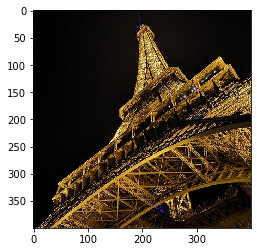

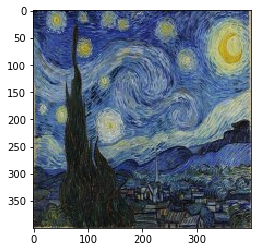

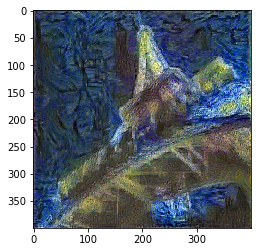

In [11]:
from matplotlib import pyplot as plt

#Curent imagine
plt.imshow(load_img(target_image_path, target_size=( img_height, img_width)))
plt.figure()

#Stilul imagini
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

#Imaginea generat
plt.imshow(img)
plt.show()